# Duboko učenje

### 3. laboratorijska vježba - Analiza klasifikacije sentimenta

*Zagreb, 24.05.2020.*

## Izjava

Tekstovi zadataka se koriste samo u edukativne svrhe, te njihova prava još uvijek pripadaju autorima. Tekstovi zadatka preuzeti su sa [sljedeće poveznice](https://dlunizg.github.io/lab3/). Također, bilo kakve izmjene su isključivo radi estetike, i ne mijenjaju intelektualnog vlasnika na mene ili bilo kog tko uređuje ovu datoteku.

## Sadržaj

- [Zadatak 1](#Zadatak-1)
- [Zadatak 2](#Zadatak-2)
- [Zadatak 3](#Zadatak-3)
- [Zadatak 4](#Zadatak-4)

# Učitavanje resursa

In [1]:
import os

Pobrinimo se da smo u korijenu projekta radi lakšeg adresiranja stvari:

In [2]:
if "--IN_ROOT" not in os.environ:
    os.environ["--IN_ROOT"] = "false"

In [3]:
if len(os.environ["--IN_ROOT"]) == 0 or os.environ["--IN_ROOT"] == "false":
    %cd ..
else:
    print(os.getcwd())

os.environ["--IN_ROOT"] = "true"

/mnt/data/projekti/faks/DUBUCE/LAB3


In [4]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [5]:
from bin.task_1 import Dataset, Vocabulary
from bin.task_2 import Baseline
from bin.task_3 import LSTM
from bin.task_4 import RecurrentModel

from util.analysis import find_all_best, \
                          get_final_dicts, \
                          get_all_final_dicts, \
                          hyperparameters_to_markdown, \
                          insert_multicategory_histogram
from util.embeddings import get_embedding_matrix, \
                            get_frequencies, \
                            pad_collate
from util.metrics import evaluate
from util.parameter_search import get_random_params
from util.paths import *                      

In [6]:
from IPython.display import display, Markdown

## Inicijalizacija globalnih varijabli

### Pokretanje zadataka

In [7]:
run_task_2 = False

run_task_3 = False

run_task_4_1 = False
run_task_4_1_final = run_task_4_1 or False

run_task_4_2 = False
run_task_4_2_final = run_task_4_2 or False

### Vokabulari

In [8]:
word_frequencies = get_frequencies(TRAIN_CSV_PATH)

data_vocab = Vocabulary(frequencies=word_frequencies,
                        max_size=-1,
                        min_freq=1,
                        additional_tokens=["<PAD>", "<UNK>"])
label_vocab = Vocabulary(frequencies={"positive": 2, "negative": 1},
                         max_size=-1,
                         min_freq=1)

### Skupovi podataka

In [9]:
tr_dataset, val_dataset, te_dataset = [Dataset(csv_file_path=path,
                                               data_vocab=data_vocab,
                                               label_vocab=label_vocab)
                                       for path in [TRAIN_CSV_PATH,
                                                    VAL_CSV_PATH,
                                                    TEST_CSV_PATH]]

### Embedding matrica

Parameter `separate_unk` određuje hoćemo li token `"<UNK>"` ostaviti da ima vrijednost definiranu zadanom vrijednošću (ako je postavljen na `False`), ili ćemo ga postaviti na $\vec{1}$ (ako je postavljen na `True`). Podrazumijevana vrijednost je `True`.

In [10]:
embedding_matrix = get_embedding_matrix(vocabulary=data_vocab,
                                        file_path=EMBEDDINGS_PATH,
                                        separate_unk=True)

# Zadatak 1

### Učitavanje podataka
*25% bodova*

#### [Zadatak 2 ->](#Zadatak-2)

#### Razred `Vocab`

Kao što smo spomenuli na predavanjima, jedan od hiperparametara svakog modela obrade prirodnog jezika je odabir veličine vokabulara, tj., broja riječi koje ćemo reprezentirati u našem modelu. Procedura odabira se u praksi provodi u nekoj vrsti `Vocab` razreda, pri izgradnji rječnika `itos` (index-to-string) i `stoi` (string-to-index).

Svakom ulaznom polju našeg skupa podataka pridodjeljujemo jedan vokabular. Vaša implementacija vokabulara se treba izgraditi temeljem rječnika frekvencija za neko polje. Rječnik frekvencija kao ključeve sadrži sve tokene koji su se pojavili u tom polju, dok su vrijednosti broj pojavljivanja svakog tokena.

Također, vaša implementacija razreda Vocab mora primati iduće parametre:

 - `max_size`: maksimalni broj tokena koji se sprema u vokabular (uključuje i posebne znakove). $-1$ označava da se spremaju svi tokeni.
 - `min_freq`: minimalna frekvencija koju token mora imati da bi ga se spremilo u vokabular ($\ge$). Posebni znakovi ne prolaze ovu provjeru.

**Bitno**: vokabular se izgrađuje samo na train skupu podataka. Jednom izgrađeni vokabular na train skupu postavljate kao vokabular testnog i validacijskog skupa podataka. Ovaj pristup se smatra najkorektniji u analizi teksta jer kroz izgradnju vokabulara na testnom i validacijskom skupu imamo curenje informacija u treniranje modela. Primjerice – u realnoj situaciji gdje deployate vaš model nije vjerojatno da će vaš model svaku viđenu riječ imati u vokabularu. Prema tome, ovakav način evaluacije, iako stroži, je realističniji.

**Odgovor**:

Ovo možemo pokazati na globalnim vokabularima:

In [11]:
for key, value in list(data_vocab.itos.items())[:5]:
    print(f"{key} -> {value}")
    
print()

for key, value in list(data_vocab.stoi.items())[:5]:
    print(f"{key}\t-> {value}")

0 -> <PAD>
1 -> <UNK>
2 -> the
3 -> a
4 -> and

<PAD>	-> 0
<UNK>	-> 1
the	-> 2
a	-> 3
and	-> 4


In [12]:
for key, value in list(label_vocab.itos.items()):
    print(f"{key} -> {value}")
    
print()

for key, value in list(label_vocab.stoi.items()):
    print(f"{key} -> {value}")

0 -> positive
1 -> negative

positive -> 0
negative -> 1


#### Učitavanje vektorskih reprezentacija

U okviru laboratorijske vježbe, uz skup podataka, dobiti ćete i podskup prednaučenih reprezentacija riječi [GloVe](https://nlp.stanford.edu/projects/glove/). Ove vektorske reprezentacije možete preuzeti [ovdje](https://drive.google.com/file/d/12mA5QEN4nFcxfEzOS8Nqj5afOmkuclc7/view).

Vaš zadatak je implementirati funkciju koja će za zadani vokabular (iterable stringova) generirati embedding matricu. Vaša funkcija treba podržavati dva načina genriranja embedding matrice: nasumična inicijalizacija iz standardne normalne razdiobe ($\mathbb{N}(0,1)$) i učitavanjem iz datoteke. Pri učitavanju iz datoteke, ako ne pronađete vektorsku reprezentaciju za neku riječ, inicijalizirajte ju normalno. Vektorsku reprezentaciju za znak punjenja (na indeksu $0$) morate inicijalizirati na vektor nula. Jednostavan način na koji možete implementirati ovo učitavanje je da inicijalirate matricu iz standardne normalne razdiobe, a potom prebrišete inicijalnu reprezentaciju u retku za svaku riječ koju učitate. Bitno: Pripazite da redoslijed vektorskih reprezentacija u matrici odgovara redoslijedu riječi u vokabularu! Npr., na indeksu 0 mora biti reprezentacija za posebni znak punjenja.

**Odgovor**:

Embedding matricu smo napravili, i ona je pohranjena kao globalna varijabla u `embedding_matrix`. Nju predajemo modelima koji potom stvaraju `torch.nn.Embedding` objekt i koriste ju prilikom rada.

In [13]:
display(Markdown(f"<br>Dimenzije te matrice su **{embedding_matrix.shape}**."))

<br>Dimenzije te matrice su **(14806, 300)**.

#### Nadjačavanje metoda `torch.utils.data.Dataset`

Da bi naša implementacija razreda `Dataset` bila potpuna, potrebno je nadjačati `__getitem__` metodu koja omogućava indeksiranje razreda. Za potrebe vježbe, ta metoda treba vraćati numerikalizirani text i labelu referencirane instance. Također, dovoljno je napraviti da se numerikalizacija radi “on-the-fly”, i nije ju nužno cachirati.

**Odgovor**:

Prikažimo primjer rada:

In [14]:
t1_data, t1_label = tr_dataset.instances[3]
t1_id_data, t1_id_label = tr_dataset[3]

In [15]:
print(f"Podatci: {t1_data}")
print(f"Oznaka: {t1_label}")

Podatci: ['yet', 'the', 'act', 'is', 'still', 'charming', 'here']
Oznaka: positive


In [16]:
t1_id_data, t1_id_label = tr_dataset[3]
print(f"Identifikatorski podatci: {t1_id_data}")
print(f"Identifikatorska oznaka: {t1_id_label}")

Identifikatorski podatci: tensor([189,   2, 674,   7, 129, 348, 143])
Identifikatorska oznaka: 0


#### Implementacija batchiranja podataka: `collate` funkcija

Skoro smo spremni za implementaciju modela – jedino što je preostalo je implementacija pretvorbi niza elemenata u batch podataka. Ovdje se ponovno susrećemo s problemom varijabilnosti dimenzije.

Pytorchev `torch.utils.data.DataLoader` pri spremanju podataka u batcheve u svojoj defaultnoj implementaciji collate funkcije očekuje da su elementi batcha jednake duljine. Ovo u tekstu nije slučaj, te u praksi moramo implementirati vlastitu collate funkciju.

**Bitno**: u vašoj collate funkciji vraćajte i duljine originalnih instanci (koje nisu nadopunjene). Duljine će nam poslužiti pri implementaciji naših modela.

Zadatak naše collate funkcije biti će nadopuniti duljine instanci znakom punjenja do duljine najdulje instance u batchu. Za ovo, pogledajte funkciju from `torch.nn.utils.rnn.pad_sequence`. Primjetite da vaša implementacija collate funkcije mora znati koji se indeks koristi kao znak punjenja.

**Odgovor**:

Prikažimo primjer rada:

In [17]:
dataloader = torch.utils.data.DataLoader(dataset=tr_dataset,
                                         batch_size=2,
                                         shuffle=False,
                                         collate_fn=pad_collate)
texts, labels, lengths = next(iter(dataloader))

In [18]:
print(f"Podatci:\n{texts}\n")
print(f"Oznake:\n{labels}\n")
print(f"Duljine: \n{lengths}\n")

Podatci:
tensor([[   2,  554,    7, 2872,    6,   22,    2, 2873, 1236,    8,   96, 4800,
            4,   10,   72,    8,  242,    6,   75,    3, 3576,   56, 3577,   34,
         2022, 2874, 7123, 3578, 7124,   42,  779, 7125,    0,    0],
        [   2, 2875, 2023, 4801,    5,    2, 3579,    5,    2, 2876, 4802,    7,
           40,  829,   10,    3, 4803,    5,  627,   62,   27, 2877, 2024, 4804,
          962,  715,    8, 7126,  555,    5, 7127, 4805,    8, 7128]])

Oznake:
tensor([0, 0])

Duljine: 
tensor([32, 34])



# Zadatak 2

### Implementacija baseline modela
*25% bodova*

#### [<- Zadatak 1](#Zadatak-1) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Zadatak 3 ->](#Zadatak-3)

Vaš zadatak u laboratorijskoj vježbi je implementirati model koji će koristiti sažimanje usrednjavanjem (*eng. mean pooling*) kako bi eliminirao problematičnu varijabilnu dimenziju. Pri primjeni sažimanja usrednjavanjem odmah eliminirajte cijelu vremensku dimenziju (tzv. *okno* je veličine $T$).

Osnovni model koji implementirate mora izgledati ovako:

```
avg_pool() -> fc(300, 150) -> ReLU() -> fc(150, 150) -> ReLU() -> fc(150,1)
```

Kao gubitak predlažemo da koristite `BCEWithLogitsLoss`, u kojem slučaju ne morate primjeniti sigmoidu na izlaznim logitima. Alternativno, možete staviti da vam je izlazna dimenzionalnost broj klasa te koristiti gubitak unakrsne entropije. Oba pristupa su korištena u praksi ovisno o osobnim preferencama.

Kao algoritam optimizacije koristite [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

Implementirajte metrike praćenja performansi modela. Osim gubitka na skupu podataka, zanimaju nas preciznost (*eng. accuracy*), [f1 mjera](https://en.wikipedia.org/wiki/F1_score) i matrica zabune (eng. *confusion matrix*). Nakon svake epohe ispišite performanse modela po svim metrikama na skupu za validaciju, a nakon zadnje epohe ispišite performanse modela na skupu za testiranje.

Postavljanje random seeda za pytorch operacije na CPU se vrši sa `torch.manual_seed(seed)`, dok istu stvar napravite i ukoliko u vašem kodu koristite numpy s `np.random.seed(seed)`. Ako pokrećete kod na grafičkoj kartici, obratite pozornost na upozorenja [ovdje](https://pytorch.org/docs/stable/notes/randomness.html#cudnn). Povratne neuronske mreže su CUDNN optimizirane, te je moguće da reproducibilnost nije 100% osigurana osim ako ne pratite upute s poveznice nauštrb brzine.

**Bitno**: Dok god rezultati vašeg koda ne variraju iznimno puno (za različita pokretanja), točne izlazne brojke ne moraju biti savršeno jednake. Kako bi provjerili varijancu (tj. stabilnost) vašeg modela, vaš konačni model pokrenite barem 5 puta s istim hiperparametrima, ali različitim seedom. Zapišite (u excel tablicu, word dokument ili slično) rezultate izvođenja (sve navedene metrike) za svaki seed. U komentar dodajte i hiperparametre za pokretanje modela.

**Odgovor**:

Konstruirajmo modele i trenirajmo ih $5$ puta:

In [19]:
if run_task_2:
    for i in range(5):
        t2_seed = np.random.randint(0, 2 ** 32)
        t2_save_folder = os.path.join(DEFAULT_SAVE_TASK2, f"run-{i + 1}")

        torch.manual_seed(t2_seed)
        np.random.seed(t2_seed)

        t2_model = Baseline(embedding_matrix=embedding_matrix,
                            units=(150, 150, 1),
                            loss=torch.nn.BCEWithLogitsLoss(),
                            freeze_embedding=False)
        t2_model.fit(dataset=tr_dataset,
                     validation_dataset=val_dataset,
                     n_epochs=5,
                     learning_rate=1e-4,
                     batch_size=10,
                     save_folder=t2_save_folder,
                     verbose=1)

        print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje 2. zadatka je postavljena na `False` "
                     "pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje 2. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Sada rezultate izvođenja možemo prikazati histogramom:

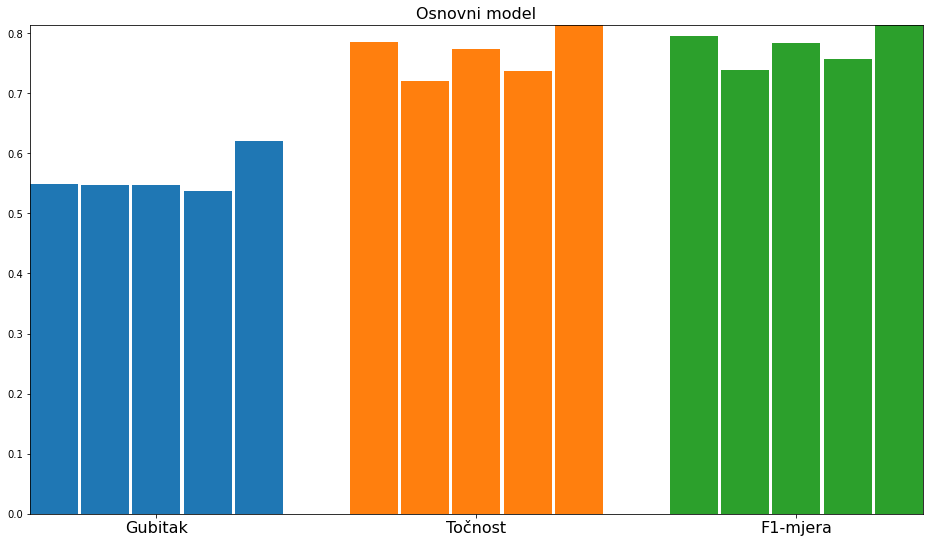

In [20]:
try:
    t2_stat_dicts = get_final_dicts(DEFAULT_SAVE_TASK2)
except Exception as e:
    print("Rezultati za 2. zadatak nisu pronađeni!")
finally:
    t2_fig, t2_ax = plt.subplots(1, 1, figsize=(16, 9))
    
    insert_multicategory_histogram(plt_axis=t2_ax,
                                   stat_dicts=t2_stat_dicts,
                                   key_order=["loss", "acc", "f1"],
                                   bar_titles=["Gubitak", "Točnost", "F1-mjera"],
                                   title="Osnovni model")

# Zadatak 3

### Implementacija povratne neuronske mreže
*25% bodova*

#### [<- Zadatak 2](#Zadatak-2) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Zadatak 4 ->](#Zadatak-4)

Nakon što ste uspješno implementirali vaš baseline model, vrijeme je da isprobamo neki model baziran na povratnim neuronskim mrežama. Vaš zadatak je implementirati osnovni model povratne neuronske meže po izboru. Na izboru su vam iduće ćelije: [“Vanilla” RNN](https://pytorch.org/docs/master/generated/torch.nn.RNN.html#torch.nn.RNN), [GRU](https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU), [LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM).

Za odabrani model, detaljno pročitajte njegovu dokumentaciju. U nastavku ćemo vam samo skrenuti pozornost na nekoliko bitnih detalja:

- Svaka RNN mreža kao izlaz svoje `forward` metode vraća
   - niz skrivenih stanja posljednjeg sloja
   - skriveno stanje (tj., skrivena stanja u slučaju LSTMa) za sve slojeve zadnjeg vremenskog koraka.
  Kao ulaz u dekoder obično želite staviti skriveno stanje iz zadnjeg sloja u zadnjem vremenskom koraku. Kod LSTMa, to je `h` komponenta dualnog `(h, c)` skrivenog stanja.
- Radi brzine, RNN mreže preferiraju inpute u `time-first` formatu (budući da je brže iterirati po prvoj dimenziji tenzora). Transponirajte ulaze prije nego ih šaljete RNN ćeliji.
- Tenzori koji su ulaz u RNN ćelije se često [“pakiraju”](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pack_padded_sequence.html#torch.nn.utils.rnn.pack_padded_sequence). Pakiranje je zapis tenzora kojemu su pridružene stvarne duljine svakog elementa u batchu. Ako koristite pakiranje, RNN mreža se neće odmatati za vremenske korake koji sadrže padding u elementima batcha. Ovdje osim efikasnosti možete dobiti i na preciznosti, ali ovaj dio nije nužan dio vaše implementacije.
- Implementirajte [gradient clipping](https://pytorch.org/docs/master/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_) prije optimizacijskog koraka

Osnovni model vaše odabrane RNN ćelije treba izgledati ovako:

```
rnn(150) -> rnn(150) -> fc(150, 150) -> ReLU() -> fc(150,1)
```

Vaš osnovni model RNN ćelije bi trebao biti jednosmjeran i imati dva sloja. Za višeslojni RNN iskoristite argument `num_layers` pri konstrukciji RNN mreže.

**Odgovor**:

Konstruirajmo modele i trenirajmo ih $5$ puta:

In [21]:
if run_task_3:
    for i in range(5):
        t3_seed = np.random.randint(0, 2 ** 32)
        t3_save_folder = os.path.join(DEFAULT_SAVE_TASK3, f"run-{i + 1}")

        torch.manual_seed(t3_seed)
        np.random.seed(t3_seed)

        t3_model = LSTM(embedding_matrix=embedding_matrix,
                        rnn_units=(150, 150),
                        fc_units=(150, 1),
                        loss=torch.nn.BCEWithLogitsLoss(),
                        freeze_embedding=False)
        t3_model.fit(dataset=tr_dataset,
                     validation_dataset=val_dataset,
                     n_epochs=5,
                     learning_rate=1e-4,
                     batch_size=10,
                     gradient_clipping=0.25,
                     save_folder=t3_save_folder,
                     verbose=1)

        print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje 3. zadatka je postavljena na `False` "
                     "pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje 3. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Sada rezultate izvođenja možemo prikazati histogramom, i usporediti ih s baseline modelom:

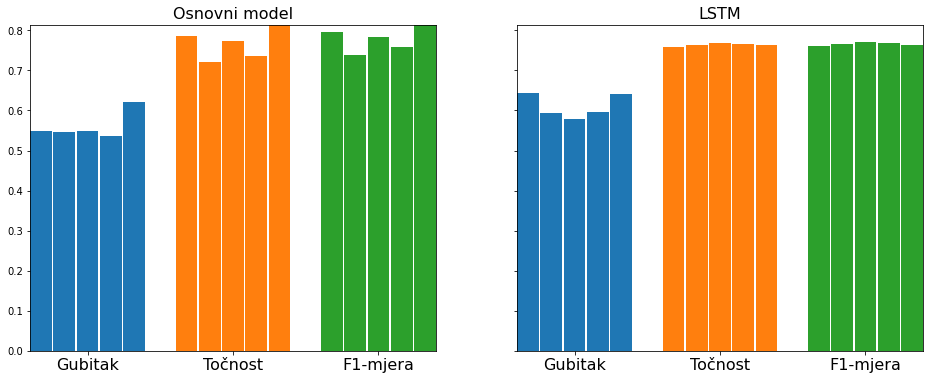

In [22]:
try:
    t3_stat_dicts = get_final_dicts(DEFAULT_SAVE_TASK3)
except Exception as e:
    print("Rezultati za 3. zadatak nisu pronađeni!")
finally:
    t3_fig, t3_ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    insert_multicategory_histogram(plt_axis=t3_ax[0],
                                   stat_dicts=t2_stat_dicts,
                                   key_order=["loss", "acc", "f1"],
                                   bar_titles=["Gubitak", "Točnost", "F1-mjera"],
                                   title="Osnovni model")
    
    insert_multicategory_histogram(plt_axis=t3_ax[1],
                                   stat_dicts=t3_stat_dicts,
                                   key_order=["loss", "acc", "f1"],
                                   bar_titles=["Gubitak", "Točnost", "F1-mjera"],
                                   title="LSTM")

# Zadatak 4

### Usporedba modela i pretraga hiperparametara
*25% bodova*

#### [<- Zadatak 3](#Zadatak-3)

Kao što vidimo, naše incijalne implementacije modela su dosta slične po preciznosti. Kako rezultati pokretanja modela za jedan skup hiperparametara mogu biti čista sreća ili nesreća, u ovom dijelu laboratorijske vježbe ćemo implementirati iscrpnu pretragu kroz varijante modela i njihove hiperparametre.

#### Usporedba RNN ćelija

Neovisno o tome koju RNN ćeliju ste odabrali u trećem zadatku, proširite vaš kod na način da vrsta RNN ćelije bude argument. Pokrenite vaš kod za preostale vrste RNN ćelija i zapišite rezultate. Je li neka ćelija očiti pobjednik? Je li neka ćelija očiti gubitnik?

Ponovite ovu usporedbu uz izmjenu hiperparametara povratnih neuronskih mreža. Idući hiperparametri povratnih neuronskih mreža su nam interesantni:

- `hidden_size`
- `num_layers`
- `dropout`: primjenjen između uzastopnih slojeva RNNa (funkcionira samo za $2$+ slojeva)
- `bidirectional`: dimenzionalnost izlaza dvosmjerne rnn ćelije je dvostruka

Isprobajte barem $3$ različite vrijednosti za svaki hiperparametar (osim bidirectional, koji ima samo dvije vrijednosti). Način na koji ćete kombinirati te vrijednosti je potpuno na vama (iscrpna rešetkasta pretraga je vremenski previše zahtjevna). Pokrenite svaku vrstu ćelije za svaku kombinaciju hiperparametara i zapišite rezultate (relevantne metrike). Nemojte se bojati raditi agresivne izmjene u vrijednostima hiperparametara (male izmjene vam neće dati puno informacija). Primjećujete li da neki hiperparametar bitno utječe na performanse ćelija? Koji?

**Odgovor**:

Odabrat ćemo $3$ različite vrijednosti za svaki hiperparametar za svaku mrežu, te potom na za svaki tip mreže isprobati na najboljem skupu hiperparametera što se događa kad mreža ima dvosmjerne izlaze.

Izvrtimo ovo za svaki tip povratne mreže:

In [23]:
if run_task_4_1:
    t4_1_range_dict = {
        "hidden_size": (75, 601),
        "num_layers": (2, 9),
        "dropout": (0.2, 0.75)
    }

    t4_1_params_list = get_random_params(range_dict=t4_1_range_dict,
                                         amount=3)

    t4_seed = np.random.randint(0, 2 ** 32)
    
    torch.manual_seed(t4_seed)
    np.random.seed(t4_seed)
    
    for rnn_type in ["rnn", "lstm", "gru"]:
        for i, hyperparameters in enumerate(t4_1_params_list):
            t4_save_folder = os.path.join(DEFAULT_SAVE_TASK4, "part-1", rnn_type, f"run-{i + 1}")
            
            t4_model = RecurrentModel(embedding_matrix=embedding_matrix,
                                      rnn_type=rnn_type,
                                      rnn_hidden_size=hyperparameters["hidden_size"],
                                      rnn_num_layers=hyperparameters["num_layers"],
                                      rnn_dropout=hyperparameters["dropout"],
                                      rnn_bidirectional=False,
                                      fc_activation_function=torch.relu,
                                      fc_units=(150, 1),
                                      loss=torch.nn.BCEWithLogitsLoss(),
                                      freeze_embedding=False)
            t4_model.fit(dataset=tr_dataset,
                         validation_dataset=val_dataset,
                         n_epochs=5,
                         optimizer=torch.optim.Adam,
                         learning_rate=1e-4,
                         batch_size=10,
                         gradient_clipping=0.25,
                         save_folder=t4_save_folder,
                         additional_params=hyperparameters,
                         verbose=1)

            print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje 1. dijela 4. zadatka je postavljena na `False` "
                     "pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje 1. dijela 4. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Sad možemo prikazati rezultate za svaku mrežu zasebno:

In [24]:
t4_1_rnn_types = ["rnn", "lstm", "gru"]
t4_1_titles = [x.upper() for x in t4_1_rnn_types]
t4_1_key_to_label = {
    "hidden_size": "Skriveni neuroni",
    "num_layers": "Broj slojeva",
    "dropout": "Dropout"
}

<br>**Parametri**:<br>&nbsp;&nbsp;Skriveni neuroni: **156**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Broj slojeva: **6**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.2521**<br>&nbsp;&nbsp;Skriveni neuroni: **531**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Broj slojeva: **7**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.6913**<br>&nbsp;&nbsp;Skriveni neuroni: **575**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Broj slojeva: **3**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.4442**

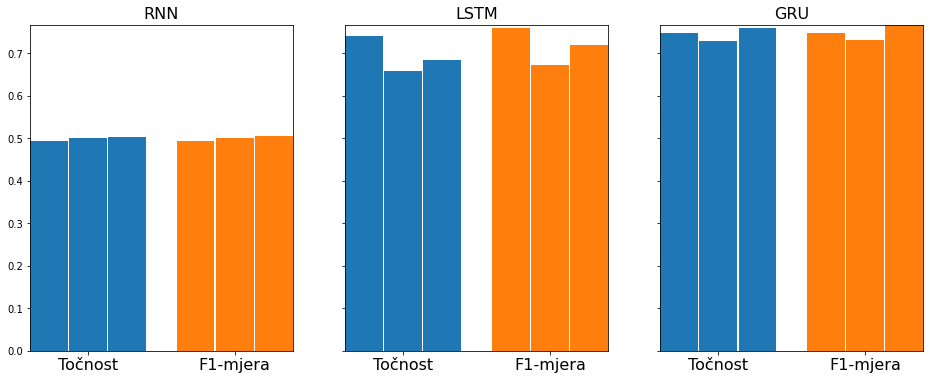

In [25]:
try:
    t4_1_stat_dicts = [get_final_dicts(os.path.join(DEFAULT_SAVE_TASK4_1, rnn_type))
                       for rnn_type in t4_1_rnn_types]
except Exception as e:
    display(Markdown("Rezultati za 1. dio 4. zadatka **nisu** pronađeni!"))
    t4_1_hyperparameters = None
finally:
    t4_1_fig, t4_1_ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    for ax, stat_dict, title in zip(t4_1_ax, t4_1_stat_dicts, t4_1_titles):
        insert_multicategory_histogram(plt_axis=ax,
                                       stat_dicts=stat_dict,
                                       key_order=["acc", "f1"],
                                       bar_titles=["Točnost", "F1-mjera"],
                                       title=title)

    t4_1_hyperparameters = [t4_1_stat_dicts[0][i]["additional_hyperparameters"]
                            for i in range(len(t4_1_stat_dicts[0]))]
    t4_1_markdown = hyperparameters_to_markdown(
        hyperparameters=t4_1_hyperparameters,
        key_to_label=t4_1_key_to_label,
        prefix="<br>**Parametri**:<br>&nbsp;&nbsp;",
        delimiter="<br>&nbsp;&nbsp;"
    )
    
    display(Markdown(t4_1_markdown))

**RNN** se čini kao najlošiji tip mreže.

Nad ovim skupom parametara najutjecajniji je dropout. Zbog toga što je u 2. skupu hiperparametara taj parametar previsok performanse mreže konzistentno pate.

Interesantno je da **LSTM** bolje radi za mrežu s manje skrivenih neurona i više slojeva, dok je **GRU** bolji uz više skrivenih neurona i manji broj slojeva.

Provjerimo sad što se događa kad najboljem modelu dodamo dvosmjernost. Uzet ćemo najbolje modele:

In [26]:
t4_1_best_dict = find_all_best(DEFAULT_SAVE_TASK4_1);

In [27]:
if run_task_4_1_final:
    t4_seed = np.random.randint(0, 2 ** 32)
    
    torch.manual_seed(t4_seed)
    np.random.seed(t4_seed)
    
    for rnn_type, hyperparameters in t4_1_best_dict.items():
        t4_data_vocab = Vocabulary(frequencies=word_frequencies,
                                   max_size=-1,
                                   min_freq=1,
                                   additional_tokens=["<PAD>", "<UNK>"])
        t4_tr_dataset, t4_val_dataset, t4_te_dataset = [Dataset(csv_file_path=path,
                                                                data_vocab=t4_data_vocab,
                                                                label_vocab=label_vocab)
                                                        for path in [TRAIN_CSV_PATH,
                                                                     VAL_CSV_PATH,
                                                                     TEST_CSV_PATH]]
        t4_embedding_matrix = get_embedding_matrix(vocabulary=t4_data_vocab,
                                                   file_path=None,
                                                   separate_unk=True)

        t4_save_folder = os.path.join(DEFAULT_SAVE_TASK4,
                                      "part-1",
                                      rnn_type, f"learn-embeddings")

        t4_model = RecurrentModel(embedding_matrix=embedding_matrix,
                                      rnn_type=rnn_type,
                                      rnn_hidden_size=hyperparameters["hidden_size"],
                                      rnn_num_layers=hyperparameters["num_layers"],
                                      rnn_dropout=hyperparameters["dropout"],
                                      rnn_bidirectional=True,
                                      fc_activation_function=torch.relu,
                                      fc_units=(150, 1),
                                      loss=torch.nn.BCEWithLogitsLoss(),
                                      freeze_embedding=False)
        t4_model.fit(dataset=tr_dataset,
                     validation_dataset=val_dataset,
                     n_epochs=5,
                     optimizer=torch.optim.Adam,
                     learning_rate=1e-4,
                     batch_size=10,
                     gradient_clipping=0.25,
                     save_folder=t4_save_folder,
                     additional_params=hyperparameters,
                     verbose=1)

        print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje konačnice 1. dijela 4. zadatka "
                     f"je postavljena na `False` pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje konačnice 1. dijela 4. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Sada možemo pogledati odnos performansi ovih novih mreža naspram starih:

In [28]:
t4_1_final_rnn_types = ["rnn", "lstm", "gru"]
t4_1_final_titles = [x.upper() for x in t4_1_final_rnn_types]
t4_1_final_key_to_label = {
    "hidden_size": "Skriveni neuroni",
    "num_layers": "Broj slojeva",
    "dropout": "Dropout"
}

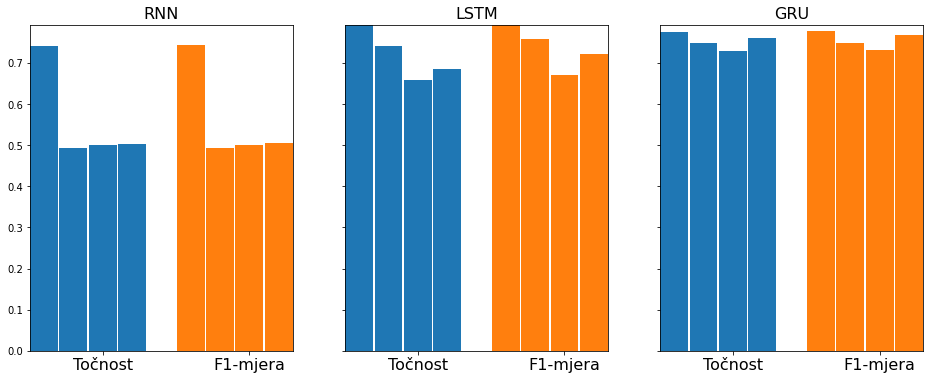

In [29]:
try:
    t4_1_final_stat_dicts = [get_final_dicts(os.path.join(DEFAULT_SAVE_TASK4_1, rnn_type),
                                             tuple())
                             for rnn_type in t4_1_rnn_types]
except Exception as e:
    display(Markdown("<br>Rezultati za konačnicu 1. dijela 4. zadatka **nisu** pronađeni!"))
finally:
    t4_1_final_fig, t4_1_final_ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    for ax, stat_dict, title in zip(t4_1_final_ax, t4_1_final_stat_dicts, t4_1_final_titles):
        insert_multicategory_histogram(plt_axis=ax,
                                       stat_dicts=stat_dict,
                                       key_order=["acc", "f1"],
                                       bar_titles=["Točnost", "F1-mjera"],
                                       title=title)

Novi rezultati su najljeviji, tj. prvi. Vidimo da smo drastično poboljšali performanse klasičnog **RNN**-a. Uvođenjem dvosmjernosti, poboljšali smo i performanse **LSTM**-a i **GRU**-a, ali ne toliko drastično. Ipak, dvosmjerni modeli su najbolji koje smo uspjeli dobiti.

#### Optimizacija hiperparametara

Probajte pokrenuti povratne neuronske mreže za najbolji set hiperparametara bez da koristite prednaučene vektorske reprezentacije. Probajte isto za vaš baseline model. Koji model više “pati” od gubitka prednaučenih reprezentacija?

Ulazne vektorske reprezentacije su jedan jako bitan hiperparametar, za koji u okviru laboratorijske vježbe imamo samo dvije vrijednosti – koristimo li ih ili ne. U analizi teksta su ulazne vektorske reprezentacije veoma velik dio uspješnosti algoritma. U ovom dijelu laboratorijske vježbe trebate odabrati barem $5$ od idućih hiperparametara te provjeriti kako modeli funkcioniraju za njihove izmjene. Ako hiperparametar utječe i na baseline model, kao i povratnu neuronsku mrežu, pokrenite eksperimente na oba modela. Za ćeliju povratne neuronske mreže odaberite onu koja ostvaruje (po vama) bolje rezultate na prošlom dijelu vježbe.

Za hiperparametre označene s nekim brojem, odaberite samo jedan od onih s istim brojem.

Hiperparametri:

- Veličina vokabulara V$^1$
- Minimalna frekvencija riječi min_freq$^1$
- Stopa učenja$^2$
- Veličina batcha$^2$
- Dropout
- Broj slojeva
- Dimenzionalnost skrivenih slojeva
- Optimizacijski algoritam (probajte nešto osim Adama)
- Funkcija nelinearnosti (u potpuno povezanim slojevima)
- Iznos na koji se podrezuju vrijednosti gradijenata
- Vrsta sažimanja (Baseline)
- Zamrzavanje ulaznih vektorskih reprezentacije (argument freeze funkcije from_pretrained)

**Odgovor**:

Odabrat ćemo sljedeći skup parametara:

- Veličina vokabulara (u rangu $\left[ 100, 14806 \right]$)
- Veličina batcha (u rangu $\left[ 1, 128 \right]$)
- Dropout (u rangu $\left[ 0, 0.75 \right]$)
- Dimenzionalnost skrivenih slojeva (u rangu $\left[ 75, 600 \right]$)
- Zamrzavanje ulaznih vektorskih reprezentacija

i napraviti $5$ uređenih četvorki uz zamrzavanje učenja embeddinga. Na kraju ćemo testirati što se događa ako dopustimo mreži da nauči embeddinge.

In [30]:
t4_2_range_dict = {
    "vocab_max_size": (100, 14807),
    "batch_size": (1, 129),
    "dropout": (0., 0.75),
    "hidden_size": (75, 601)
}

t4_2_params_list = get_random_params(range_dict=t4_2_range_dict,
                                     amount=5)

In [31]:
if run_task_4_2:
    t4_seed = np.random.randint(0, 2 ** 32)
    
    torch.manual_seed(t4_seed)
    np.random.seed(t4_seed)
    
    for rnn_type in ["rnn", "lstm", "gru"]:
        for i, hyperparameters in enumerate(t4_2_params_list):
            t4_data_vocab = Vocabulary(frequencies=word_frequencies,
                                       max_size=hyperparameters["vocab_max_size"],
                                       min_freq=1,
                                       additional_tokens=["<PAD>", "<UNK>"])
            t4_tr_dataset, t4_val_dataset, t4_te_dataset = [Dataset(csv_file_path=path,
                                                                    data_vocab=t4_data_vocab,
                                                                    label_vocab=label_vocab)
                                                            for path in [TRAIN_CSV_PATH,
                                                                         VAL_CSV_PATH,
                                                                         TEST_CSV_PATH]]
            t4_embedding_matrix = get_embedding_matrix(vocabulary=t4_data_vocab,
                                                       file_path=None,
                                                       separate_unk=True)
            
            t4_save_folder = os.path.join(DEFAULT_SAVE_TASK4, "part-2", rnn_type, f"run-{i + 1}")
            
            t4_model = RecurrentModel(embedding_matrix=t4_embedding_matrix,
                                      rnn_type=rnn_type,
                                      rnn_hidden_size=hyperparameters["hidden_size"],
                                      rnn_num_layers=2,
                                      rnn_dropout=hyperparameters["dropout"],
                                      rnn_bidirectional=False,
                                      fc_activation_function=torch.relu,
                                      fc_units=(150, 1),
                                      loss=torch.nn.BCEWithLogitsLoss(),
                                      freeze_embedding=True)
            t4_model.fit(dataset=t4_tr_dataset,
                         validation_dataset=t4_val_dataset,
                         n_epochs=5,
                         optimizer=torch.optim.Adam,
                         learning_rate=1e-4,
                         batch_size=hyperparameters["batch_size"],
                         gradient_clipping=0.25,
                         save_folder=t4_save_folder,
                         additional_params=hyperparameters,
                         verbose=1)

            print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje 2. dijela 4. zadatka je postavljena na `False` "
                     "pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje 2. dijela 4. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Opet možemo prikazati rezultate za svaku mrežu zasebno:

In [32]:
t4_2_rnn_types = ["rnn", "lstm", "gru"]
t4_2_titles = [x.upper() for x in t4_2_rnn_types]
t4_2_key_to_label = {
    "vocab_max_size": "Maksimum broja riječi u vokabularu",
    "hidden_size": "Skriveni neuroni",
    "batch_size": "Veličina grupa",
    "dropout": "Dropout"
}

<br>**Parametri**:<br>&nbsp;&nbsp;Maksimum broja riječi u vokabularu: **2817**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Veličina grupa: **117**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.0336**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Skriveni neuroni: **214**<br>&nbsp;&nbsp;Maksimum broja riječi u vokabularu: **7691**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Veličina grupa: **13**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.0956**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Skriveni neuroni: **594**<br>&nbsp;&nbsp;Maksimum broja riječi u vokabularu: **8583**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Veličina grupa: **42**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.3360**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Skriveni neuroni: **384**<br>&nbsp;&nbsp;Maksimum broja riječi u vokabularu: **11165**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Veličina grupa: **125**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.2735**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Skriveni neuroni: **121**<br>&nbsp;&nbsp;Maksimum broja riječi u vokabularu: **3184**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Veličina grupa: **1**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout: **0.0044**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Skriveni neuroni: **581**

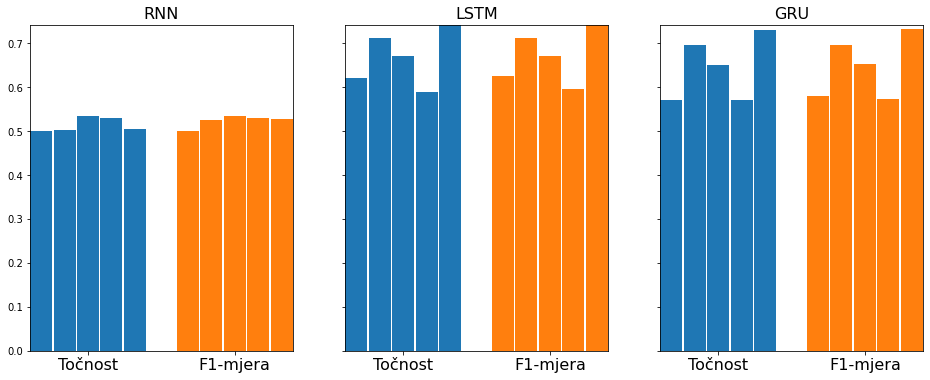

In [33]:
try:
    t4_2_stat_dicts = [get_final_dicts(os.path.join(DEFAULT_SAVE_TASK4_2, rnn_type))
                       for rnn_type in t4_2_rnn_types]
except Exception as e:
    display(Markdown("<br>Rezultati za 2. dio 4. zadatka **nisu** pronađeni!"))
    t4_2_hyperparameters = None
finally:
    t4_2_fig, t4_2_ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    for ax, stat_dict, title in zip(t4_2_ax, t4_2_stat_dicts, t4_2_titles):
        insert_multicategory_histogram(plt_axis=ax,
                                       stat_dicts=stat_dict,
                                       key_order=["acc", "f1"],
                                       bar_titles=["Točnost", "F1-mjera"],
                                       title=title)

    t4_2_hyperparameters = [t4_2_stat_dicts[0][i]["additional_hyperparameters"]
                            for i in range(len(t4_2_stat_dicts[0]))]
    t4_2_markdown = hyperparameters_to_markdown(
        hyperparameters=t4_2_hyperparameters,
        key_to_label=t4_2_key_to_label,
        prefix="<br>**Parametri**:<br>&nbsp;&nbsp;",
        delimiter="<br>&nbsp;&nbsp;"
    )
    
    display(Markdown(t4_2_markdown))

Na grafovima je vidljivo da najbolje performanse postižu 2. i 5. skup parametara.

Ako pogledamo 5. skup parametara, vidjet ćemo da ima drugi najmanji vokabular, srezan je na oko $\frac{1}{5}$ originalnog vokabulara, međutim ima velik broj skrivenih neurona, veličinu grupe 1 i jako niski dropout. Vidimo da performansama vjerojatno najviše pridonose veličina grupe i skriveni neuroni - 4. skup parametara dao je najgore rezultate za **LSTM** i **GRU**, a ostali parametri smatraju se poželjnima.

Ako pogledamo 2. skup parametara, koji je ujedno i 2. najbolji, vidimo da ovdje imamo veći vokabular i velik broj skrivenih neurona. Ono što je drukčije je blago veći dropout i veličina grupa. Stoga možemo zaključiti da veličine grupa dosta utječu na performanse.

Sada možemo pronaći najbolje mreže i pokušati ih trenirati uz učenje s rječnikom:

In [34]:
t4_2_best_dict = find_all_best(DEFAULT_SAVE_TASK4_2);

In [35]:
if run_task_4_2_final:
    t4_seed = np.random.randint(0, 2 ** 32)
    
    torch.manual_seed(t4_seed)
    np.random.seed(t4_seed)
    
    for rnn_type, hyperparameters in t4_2_best_dict.items():
        t4_data_vocab = Vocabulary(frequencies=word_frequencies,
                                   max_size=hyperparameters["vocab_max_size"],
                                   min_freq=1,
                                   additional_tokens=["<PAD>", "<UNK>"])
        t4_tr_dataset, t4_val_dataset, t4_te_dataset = [Dataset(csv_file_path=path,
                                                                data_vocab=t4_data_vocab,
                                                                label_vocab=label_vocab)
                                                        for path in [TRAIN_CSV_PATH,
                                                                     VAL_CSV_PATH,
                                                                     TEST_CSV_PATH]]
        t4_embedding_matrix = get_embedding_matrix(vocabulary=t4_data_vocab,
                                                   file_path=None,
                                                   separate_unk=True)

        t4_save_folder = os.path.join(DEFAULT_SAVE_TASK4,
                                      "part-2",
                                      rnn_type, f"learn-embeddings")

        t4_model = RecurrentModel(embedding_matrix=t4_embedding_matrix,
                                  rnn_type=rnn_type,
                                  rnn_hidden_size=hyperparameters["hidden_size"],
                                  rnn_num_layers=2,
                                  rnn_dropout=hyperparameters["dropout"],
                                  rnn_bidirectional=False,
                                  fc_activation_function=torch.relu,
                                  fc_units=(150, 1),
                                  loss=torch.nn.BCEWithLogitsLoss(),
                                  freeze_embedding=False)
        t4_model.fit(dataset=t4_tr_dataset,
                     validation_dataset=t4_val_dataset,
                     n_epochs=5,
                     optimizer=torch.optim.Adam,
                     learning_rate=1e-4,
                     batch_size=hyperparameters["batch_size"],
                     gradient_clipping=0.25,
                     save_folder=t4_save_folder,
                     additional_params=hyperparameters,
                     verbose=1)

        print("\n")
else:
    display(Markdown("<br>Zastavica za pokretanje konačnice 2. dijela 4. zadatka "
                     f"je postavljena na `False` pa zadatak nije pokrenut."))

<br>Zastavica za pokretanje konačnice 2. dijela 4. zadatka je postavljena na `False` pa zadatak nije pokrenut.

Sada možemo pogledati odnos performansi ovih novih mreža naspram starih:

In [36]:
t4_2_final_rnn_types = ["rnn", "lstm", "gru"]
t4_2_final_titles = [x.upper() for x in t4_2_final_rnn_types]
t4_2_final_key_to_label = {
    "vocab_max_size": "Maksimum broja riječi u vokabularu",
    "hidden_size": "Skriveni neuroni",
    "batch_size": "Veličina grupa",
    "dropout": "Dropout"
}

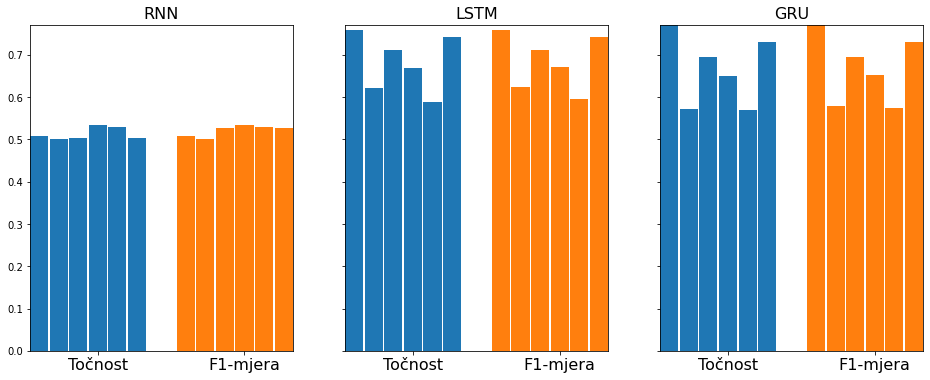

In [37]:
try:
    t4_2_final_stat_dicts = [get_final_dicts(os.path.join(DEFAULT_SAVE_TASK4_2, rnn_type),
                                             tuple())
                             for rnn_type in t4_2_rnn_types]
except Exception as e:
    display(Markdown("<br>Rezultati za konačnicu 2. dijela 4. zadatka **nisu** pronađeni!"))
finally:
    t4_2_final_fig, t4_2_final_ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    for ax, stat_dict, title in zip(t4_2_final_ax, t4_2_final_stat_dicts, t4_2_final_titles):
        insert_multicategory_histogram(plt_axis=ax,
                                       stat_dicts=stat_dict,
                                       key_order=["acc", "f1"],
                                       bar_titles=["Točnost", "F1-mjera"],
                                       title=title)

Novi rezultati su opet najljeviji, tj. prvi. Vidimo da za **LSTM** i **GRU** imamo najveća poboljšanja. U slučaja **RNN**-a, ne uspijevamo dobiti bolje performanse od prethodnog najboljeg modela.